In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import tensorflow as tf
import numpy as np
import warnings
import os.path as osp
import time

from scipy.stats import entropy
from general_tools.simpletons import iterate_in_chunks

from tf_lab.external.Chamfer_EMD_losses.tf_nndistance import nn_distance
from tf_lab.external.Chamfer_EMD_losses.tf_approxmatch import approx_match, match_cost

import time
from geo_tool import Point_Cloud

In [ ]:
%matplotlib inline

In [58]:
def minimum_mathing_distance_tf_graph(n_pc_points, batch_size, normalize=False, sess=None, verbose=False, use_sqrt=False, use_EMD=False):
    ''' normalize (boolean): if True the Chamfer distance between two point-clouds is the average of matched
                             point-distances. Alternatively, is their sum.
    '''
    if normalize:
        reducer = tf.reduce_mean
    else:
        reducer = tf.reduce_sum

    if sess is None:
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)

    # TF Graph Operations
    ref_pl = tf.placeholder(tf.float32, shape=(1, n_pc_points, 3))
    sample_pl = tf.placeholder(tf.float32, shape=(None, n_pc_points, 3))

    repeat_times = tf.shape(sample_pl)[0]   # slower- could be used to use entire set of samples.
#     repeat_times = batch_size
    ref_repeat = tf.tile(ref_pl, [repeat_times, 1, 1])
    ref_repeat = tf.reshape(ref_repeat, [repeat_times, n_pc_points, 3])

    if not use_EMD:
        ref_to_s, _, s_to_ref, _ = nn_distance(ref_repeat, sample_pl)

        if use_sqrt:
            ref_to_s = tf.sqrt(ref_to_s)
            s_to_ref = tf.sqrt(s_to_ref)

        all_dist_in_batch = reducer(ref_to_s, 1) + reducer(s_to_ref, 1)
    else:
        match = approx_match(ref_repeat, sample_pl)
        all_dist_in_batch = match_cost(ref_repeat, sample_pl, match)

    best_in_batch = tf.reduce_min(all_dist_in_batch)   # Best distance, of those that were matched to single ref pc.
    location_of_best = tf.argmin(all_dist_in_batch, axis=0)
    return ref_pl, sample_pl, best_in_batch, location_of_best, sess

In [47]:
def minimum_mathing_distance(sample_pcs, ref_pcs, batch_size, normalize=False, sess=None, verbose=False, use_sqrt=False, use_EMD=False):
    ''' normalize (boolean): if True the Chamfer distance between two point-clouds is the average of matched
                             point-distances. Alternatively, is their sum.
    '''
            
    n_ref, n_pc_points, pc_dim = ref_pcs.shape
    _, n_pc_points_s, pc_dim_s = sample_pcs.shape

    if n_pc_points != n_pc_points_s or pc_dim != pc_dim_s:
        raise ValueError('Incompatible Point-Clouds.')

    ref_pl, sample_pl, best_in_batch, _, sess = minimum_mathing_distance_tf_graph(n_pc_points, batch_size, 
                                                            normalize=normalize, sess=sess, 
                                                            use_sqrt=use_sqrt, use_EMD=use_EMD)
    matched_dists = []
    for i in xrange(n_ref):
        best_in_all_batches = []
        if verbose and i % 50 == 0:
            print i
        for sample_chunk in iterate_in_chunks(sample_pcs, batch_size):
            feed_dict = {ref_pl: np.expand_dims(ref_pcs[i], 0), sample_pl: sample_chunk}
            b = sess.run(best_in_batch, feed_dict=feed_dict)
            best_in_all_batches.append(b)
        matched_dists.append(np.min(best_in_all_batches))
    mmd = np.mean(matched_dists)
    return mmd, matched_dists

In [188]:
def coverage(sample_pcs, ref_pcs, batch_size, normalize=False, sess=None, verbose=False, use_sqrt=False, use_EMD=False):
    ''' normalize (boolean): if True the Chamfer distance between two point-clouds is the average of matched
                             point-distances. Alternatively, is their sum.
    '''
            
    n_ref, n_pc_points, pc_dim = ref_pcs.shape
    n_sam, n_pc_points_s, pc_dim_s = sample_pcs.shape

    if n_pc_points != n_pc_points_s or pc_dim != pc_dim_s:
        raise ValueError('Incompatible Point-Clouds.')

    ref_pl, sample_pl, best_in_batch, loc_of_best, sess = minimum_mathing_distance_tf_graph(n_pc_points, batch_size, 
                                                            normalize=normalize, sess=sess, 
                                                            use_sqrt=use_sqrt, use_EMD=use_EMD)
    matched_gt = []
    for i in xrange(n_sam):
        
        best_in_all_batches = []
        loc_in_all_batches = []
        
        if verbose and i % 50 == 0:
            print i
        
        for ref_chunk in iterate_in_chunks(ref_pcs, batch_size):
            feed_dict = {ref_pl: np.expand_dims(sample_pcs[i], 0), sample_pl: ref_chunk}    
            b, loc = sess.run([best_in_batch, loc_of_best], feed_dict=feed_dict)
            best_in_all_batches.append(b)
            loc_in_all_batches.append(loc)
        
        b_hit = np.argmin(np.array(best_in_all_batches)) # In which batch it occured.
        hit = np.array(loc_in_all_batches)[b_hit]
        matched_gt.append(batch_size * b_hit + hit)
    return matched_gt

In [85]:
a = np.random.randn(60, 2048, 3)
b = np.random.randn(60, 2048, 3)

In [163]:
# a = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/r_gan_chair_mlp_disc_4_fc_gen_raw_gan_2048_pts/epoch_1900.npz'
a = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/l_w_gan/l_w_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch/epoch_2000.npz'
a = np.load(a)
a = a[a.keys()[0]]

In [164]:
b = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/gt_data/chair_test.npz'
b = np.load(b)
b = b[b.keys()[0]]

In [168]:
matched_idx1 = matched_idx

In [189]:
s = time.time()
matched_idx = coverage(a[:13], a[:13], 3, use_EMD=True)
print time.time() - s

2.82326006889


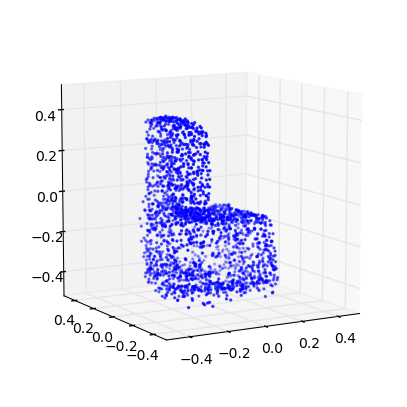

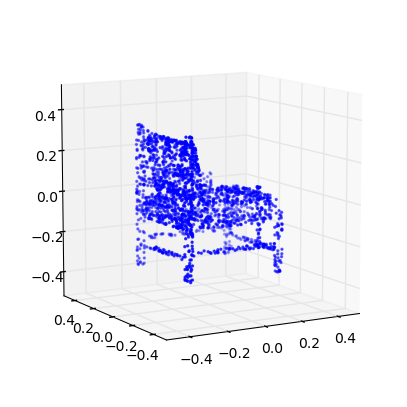

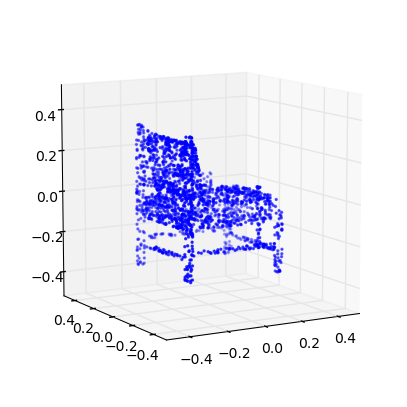

In [191]:
k = 2
Point_Cloud(a[:20][k]).plot()
Point_Cloud(b[:20][matched_idx[k]]).plot()

In [118]:
float(len(np.unique(lala))) / len(b)

0.5655375552282769

In [ ]:
#For histogram comparissons.
l_h = np.load('l_emd_hist_test.npz')
l_h = l_h[l_h.keys()[0]]
r_h = np.array(all_d['test'])
bins = np.linspace(-0.000001, np.max([r_h, l_h]), 100)               
plt.hist(r_h, bins, alpha=0.5, label='raw')
plt.hist(l_h, bins, alpha=0.5, label='l_emd')
plt.legend(loc='upper right')